<a href="https://colab.research.google.com/github/duybluemind1988/project_py/blob/main/Churn/Churn_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import compose
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold,train_test_split,cross_val_score,cross_validate
#ML normal ML
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#ML ensembles
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import recall_score,precision_score,roc_curve,auc,precision_recall_curve
from sklearn.metrics import f1_score,balanced_accuracy_score,average_precision_score
from sklearn.metrics import make_scorer

# explain
import shap
import dalex as dx

# OOP python for feature engineering
from sklearn.base import BaseEstimator, TransformerMixin

In [6]:
path='https://raw.githubusercontent.com/rstudio/keras-customer-churn/master/data/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df=pd.read_csv(path)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
target="Churn"
X = df.drop(columns=target)
y= df[target]
print(X.shape)
print(y.shape)
X_train_a, X_test, y_train_a, y_test = model_selection.train_test_split(X,y, test_size=0.2, 
                                    random_state=2018, stratify=y)

X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_a, y_train_a,test_size=0.2, 
                                    random_state=2018, stratify=y_train_a)

(7043, 20)
(7043,)


In [ ]:
# Drop columns features
class DropSomeColumns(BaseEstimator, TransformerMixin):

    def __init__(self, feature_name):
        self.feature_name = feature_name

    def fit(self, X: pd.DataFrame, y: pd.Series):
        # there is nothing to fit
        return self

    def transform(self, X:pd.DataFrame):
        X = X.copy() # creating a copy to avoid changes to original dataset
        X = X.drop(columns=self.feature_name)
        #X = X[self.feature_name]
        return X

In [ ]:
# Remove "" in object column and convert to number
class Convert_to_number(BaseEstimator, TransformerMixin):

    def __init__(self, feature_name):
        self.feature_name = feature_name

    def fit(self, X: pd.DataFrame, y: pd.Series):
        # there is nothing to fit
        return self

    def transform(self, X:pd.DataFrame):
        X = X.copy() # creating a copy to avoid changes to original dataset
        X[self.feature_name] = X[self.feature_name].replace(' ', np.nan).astype(float)
        #X = X[self.feature_name]
        return X

In [ ]:
pipe=pipeline.Pipeline(steps=[
                    ("DropSomeColumns",DropSomeColumns("customerID")),
                    ("Convert_to_number",Convert_to_number("TotalCharges"))
                    ]
             )

In [ ]:
X_train=pipe.transform(X_train)
X_val=pipe.transform(X_val)
X_test=pipe.transform(X_test)

In [ ]:
# Label encoder target
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train=le.transform(y_train)
y_val=le.transform(y_val)
y_test=le.transform(y_test)

In [ ]:
# Define categorical columns
categorical = list(X_train.select_dtypes('object').columns)
# Define numerical columns
numerical = list(X_train.select_dtypes('number').columns)

In [ ]:
# Combine categorical and numerical pipelines
preprocessor = compose.ColumnTransformer(transformers=[
                                                ('cat', preprocessing.OneHotEncoder(), categorical),
                                                #('cat', preprocessing.OrdinalEncoder(), categorical),
                                                ('num', preprocessing.StandardScaler(), numerical)
                                                      ])

In [ ]:
# Now we have a full prediction pipeline.
model = pipeline.Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LGBMClassifier())])

In [ ]:
model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                        

In [ ]:
y_pred=model.predict(X_test)
y_pred_probs=model.predict_proba(X_test)
print(metrics.confusion_matrix(y_test,y_pred))
print('Balanced Accuracy score:',metrics.balanced_accuracy_score(y_test,y_pred))
print('f1 macro score:',metrics.f1_score(y_test,y_pred,average="macro")) # good for imbalance dataset
print('precision macro score:',metrics.precision_score(y_test,y_pred,average="macro"))
print('recall macro score:',metrics.recall_score(y_test,y_pred,average="macro"))
#fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:,1],pos_label='Yes') # convert label to yes/no
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:,1])
print("AUC:",metrics.auc(fpr, tpr))
print("MCC:",metrics.matthews_corrcoef(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[904 131]
 [176 198]]
Balanced Accuracy score: 0.7014208581983519
f1 macro score: 0.7090732389724551
precision macro score: 0.719430372621862
recall macro score: 0.7014208581983519
AUC: 0.8346624815934279
MCC: 0.4204657130767243
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1035
           1       0.60      0.53      0.56       374

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.77      0.78      0.78      1409



In [ ]:
#df[df["TotalCharges"]==" "] # 488,753,936,1082,1340,3331
#df[df["Churn"]=="Yes"] # 2,5,8,7032,7034

In [ ]:
test1 =df.iloc[[1]].drop(columns="Churn") # NO, No Na in Total charge (convert to data frame)
test2 = df.iloc[[488]].drop(columns="Churn")  # NO, Na in total charge (convert to data frame)
test3 = df.iloc[[2]].drop(columns="Churn")  # YES, 
test4 = df.iloc[[4]].drop(columns="Churn")  # YES

In [ ]:
customerA = pipe.transform(test1)# NO
customerB = pipe.transform(test3) # YES
customerA

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5


In [ ]:
customerB

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15


In [ ]:
model_exp = dx.Explainer(model, X_train, y_train, 
                          label = "model Pipeline")

Preparation of a new explainer is initiated

  -> data              : 4507 rows 19 cols
  -> target variable   : 4507 values
  -> model_class       : lightgbm.sklearn.LGBMClassifier (default)
  -> label             : model Pipeline
  -> predict function  : <function yhat_proba_default at 0x7fe9208d4040> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.000198, mean = 0.266, max = 0.963
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.892, mean = -0.00015, max = 0.919
  -> model_info        : package sklearn

A new explainer has been created!


In [ ]:
#bd_henry = model_exp.predict_parts(customerA, 
#             type = 'break_down')
#bd_henry

In [ ]:
#print(test1["Churn"])
#print(model.predict_proba(customerA))
#print(test4["Churn"])
#print(model.predict_proba(customerB))

6 Break-down Plots for Additive Attributions

In [ ]:
bd_henry = model_exp.predict_parts(customerA, 
             type = 'break_down')
bd_henry.plot() # max_vars =45

In [ ]:
bd_henry = model_exp.predict_parts(customerB, 
             type = 'break_down')
bd_henry.plot()

7 Break-down Plots for Interactions

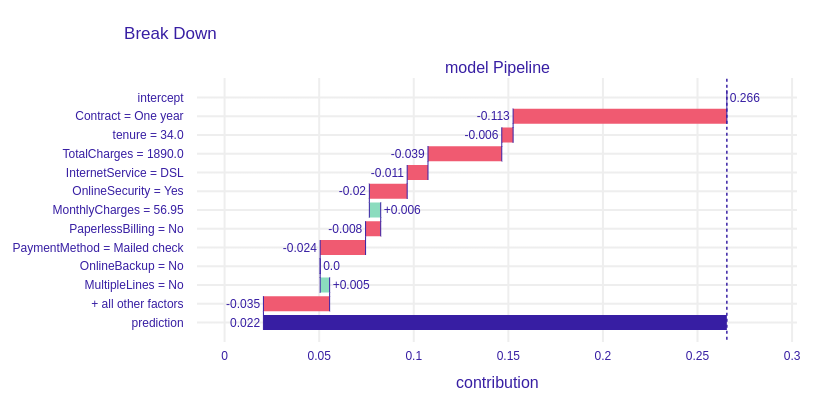

In [ ]:
bd_henry = model_exp.predict_parts(customerA, 
             type = 'break_down_interactions')
bd_henry.plot()

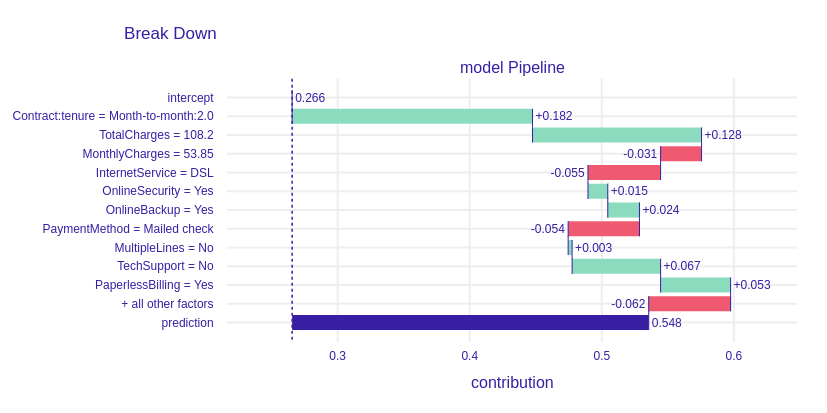

In [ ]:
bd_henry = model_exp.predict_parts(customerB, 
             type = 'break_down_interactions')
bd_henry.plot()

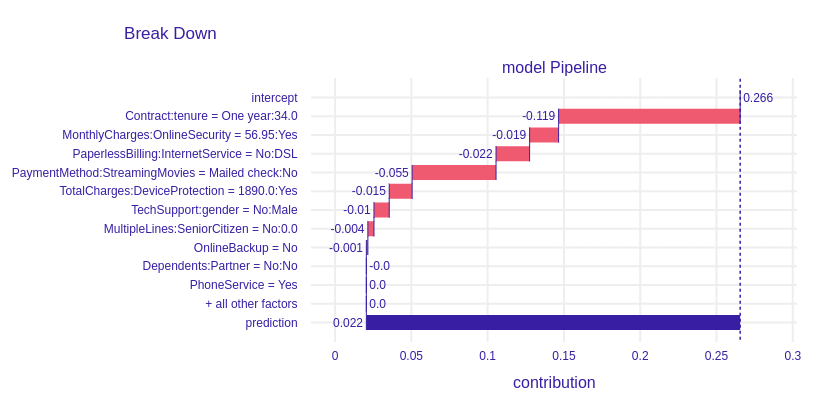

In [ ]:
bd_henry = model_exp.predict_parts(customerA, 
             type = 'break_down_interactions',interaction_preference = 10)
bd_henry.plot()

8 Shapley Additive Explanations (SHAP) for Average Attributions

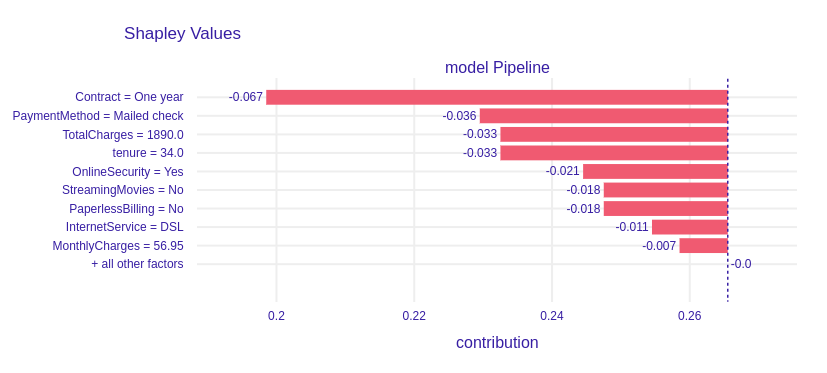

In [ ]:
bd_henry = model_exp.predict_parts(customerA, 
             type = 'shap')
bd_henry.plot(max_vars =10)

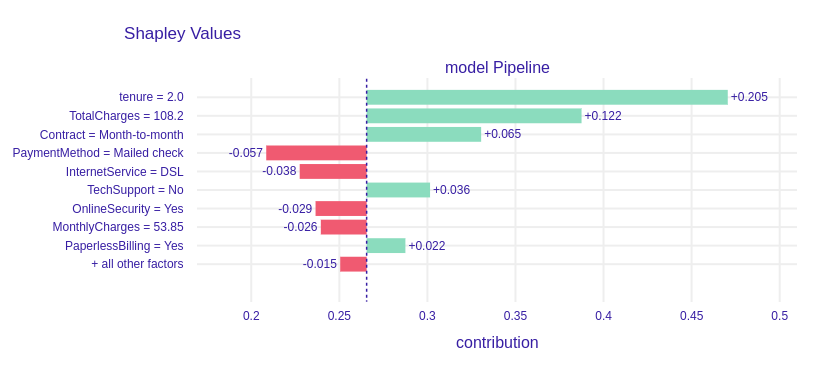

In [ ]:
bd_henry = model_exp.predict_parts(customerB, 
             type = 'shap')
bd_henry.plot(max_vars =10)

9 Local Interpretable Model-agnostic Explanations (LIME)

In [ ]:
from lime.lime_tabular import LimeTabularExplainer 
explainer = LimeTabularExplainer(X_train, 
                      feature_names=X_train.columns, 
                      #class_names=['No', 'Yes'], 
                      discretize_continuous=False, 
                      mode='classification',           
                      verbose=True)

ValueError: could not convert string to float: 'Male'

In [ ]:
# Must label encoder tareget to use LIME explaination
# Must convert data frame to series (df.squeeze())
lime = explainer.explain_instance(customerA.squeeze(), model.predict_proba) # Must remove NA for LIME explain
lime.show_in_notebook(show_table=True)
lime.as_pyplot_figure()
plt.show()

NameError: name 'explainer' is not defined

In [ ]:
y_test[0:10]

In [ ]:
# Must label encoder tareget to use LIME explaination
lime = explainer.explain_instance(X_test.iloc[6], model.predict_proba) # Must remove NA for LIME explain
lime.show_in_notebook(show_table=True)
lime.as_pyplot_figure()
plt.show()

In [ ]:
pd.DataFrame(lime.as_list())

10 Ceteris-paribus Profiles

In [ ]:
cp_henry = model_exp.predict_profile(customerB)
cp_henry.result

Calculating ceteris paribus: 100%|██████████| 19/19 [00:00<00:00, 108.39it/s]


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,_original_,_yhat_,_vname_,_ids_,_label_
2,Male,0.00,No,No,2.0,Yes,No,DSL,Yes,Yes,...,Month-to-month,Yes,Mailed check,53.85,108.150,Male,0.547896,gender,2,model Pipeline
2,Female,0.00,No,No,2.0,Yes,No,DSL,Yes,Yes,...,Month-to-month,Yes,Mailed check,53.85,108.150,Male,0.517130,gender,2,model Pipeline
2,Male,0.00,No,No,2.0,Yes,No,DSL,Yes,Yes,...,Month-to-month,Yes,Mailed check,53.85,108.150,0,0.547896,SeniorCitizen,2,model Pipeline
2,Male,0.01,No,No,2.0,Yes,No,DSL,Yes,Yes,...,Month-to-month,Yes,Mailed check,53.85,108.150,0,0.547896,SeniorCitizen,2,model Pipeline
2,Male,0.02,No,No,2.0,Yes,No,DSL,Yes,Yes,...,Month-to-month,Yes,Mailed check,53.85,108.150,0,0.547896,SeniorCitizen,2,model Pipeline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,Male,0.00,No,No,2.0,Yes,No,DSL,Yes,Yes,...,Month-to-month,Yes,Mailed check,53.85,8251.376,108.15,0.459529,TotalCharges,2,model Pipeline
2,Male,0.00,No,No,2.0,Yes,No,DSL,Yes,Yes,...,Month-to-month,Yes,Mailed check,53.85,8337.132,108.15,0.459529,TotalCharges,2,model Pipeline
2,Male,0.00,No,No,2.0,Yes,No,DSL,Yes,Yes,...,Month-to-month,Yes,Mailed check,53.85,8422.888,108.15,0.459529,TotalCharges,2,model Pipeline
2,Male,0.00,No,No,2.0,Yes,No,DSL,Yes,Yes,...,Month-to-month,Yes,Mailed check,53.85,8508.644,108.15,0.459529,TotalCharges,2,model Pipeline


In [ ]:
pd.set_option('display.max_columns', None)
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
731,Male,0,No,No,5,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.35,92.75
5546,Male,0,No,No,4,No,No phone service,DSL,Yes,Yes,No,Yes,No,No,Month-to-month,No,Mailed check,42.40,146.40
3023,Male,0,Yes,Yes,72,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),89.70,6339.30
3914,Male,0,No,No,39,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.90,791.15
4787,Female,0,Yes,No,4,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,No,Mailed check,54.70,235.05


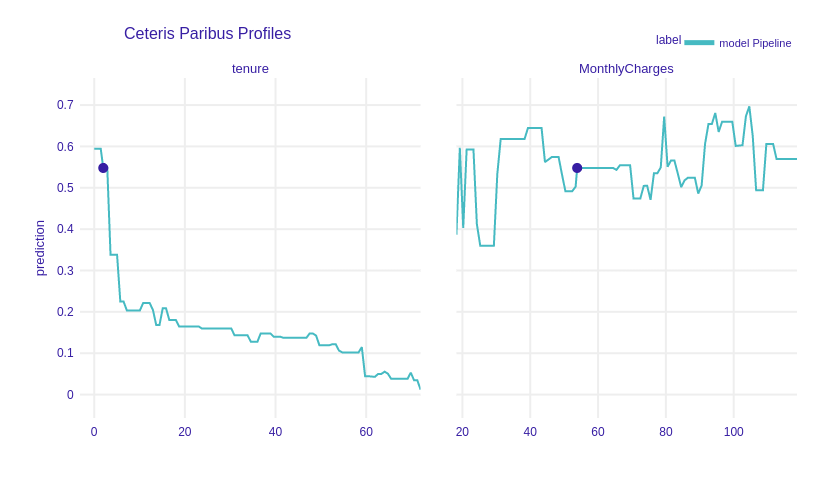

In [ ]:
cp_henry.plot(variables = ['tenure', 'MonthlyCharges'])

In [ ]:
X_train

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
731,Male,0,No,No,5,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.35,92.75
5546,Male,0,No,No,4,No,No phone service,DSL,Yes,Yes,No,Yes,No,No,Month-to-month,No,Mailed check,42.40,146.40
3023,Male,0,Yes,Yes,72,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),89.70,6339.30
3914,Male,0,No,No,39,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.90,791.15
4787,Female,0,Yes,No,4,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,No,Mailed check,54.70,235.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,Male,0,No,No,12,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),20.05,267.00
3170,Male,0,No,No,28,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,One year,No,Electronic check,100.20,2688.45
1222,Male,0,Yes,Yes,64,Yes,No,DSL,Yes,No,Yes,Yes,Yes,No,Two year,No,Mailed check,69.25,4447.75
5109,Male,0,Yes,Yes,66,Yes,No,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,Mailed check,65.85,4097.05


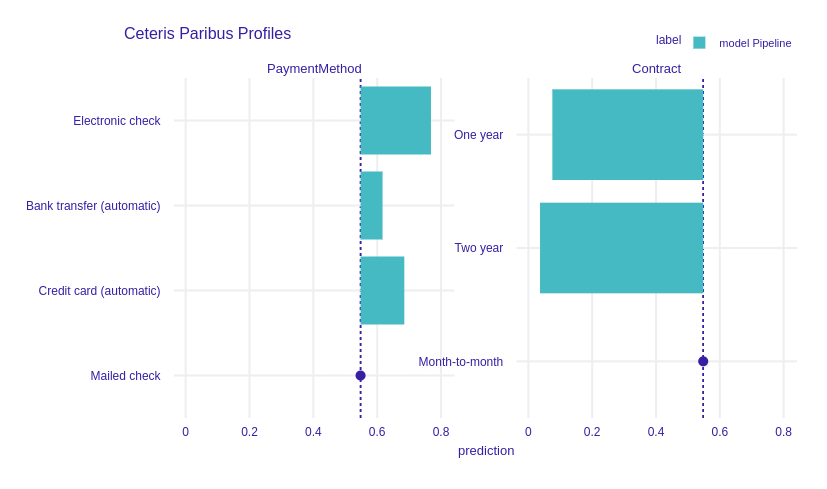

In [ ]:
cp_henry.plot(variables = ['PaymentMethod',"Contract"],variable_type = 'categorical')

15 Model-performance Measures

In [ ]:
import dalex as dx
model_exp = dx.Explainer(model, X_train, y_train, 
                  label = "Titanic RF Pipeline")

Preparation of a new explainer is initiated

  -> data              : 4507 rows 19 cols
  -> target variable   : 4507 values
  -> model_class       : lightgbm.sklearn.LGBMClassifier (default)
  -> label             : Titanic RF Pipeline
  -> predict function  : <function yhat_proba_default at 0x7febd5332790> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.000198, mean = 0.266, max = 0.963
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.892, mean = -0.00015, max = 0.919
  -> model_info        : package sklearn

A new explainer has been created!


In [ ]:
mp_rf = model_exp.model_performance(model_type = "classification", 
          cutoff = 0.5)
mp_rf.result

,recall,precision,f1,accuracy,auc
Titanic RF Pipeline,0.765886,0.852093,0.806693,0.902596,0.964482


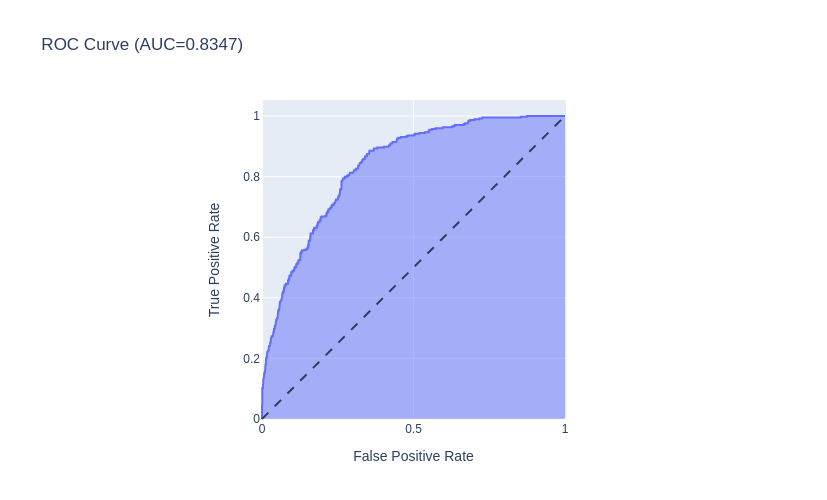

In [ ]:
import plotly.express as px
from sklearn.metrics import roc_curve, auc
y_score = model_exp.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)
fig = px.area(x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

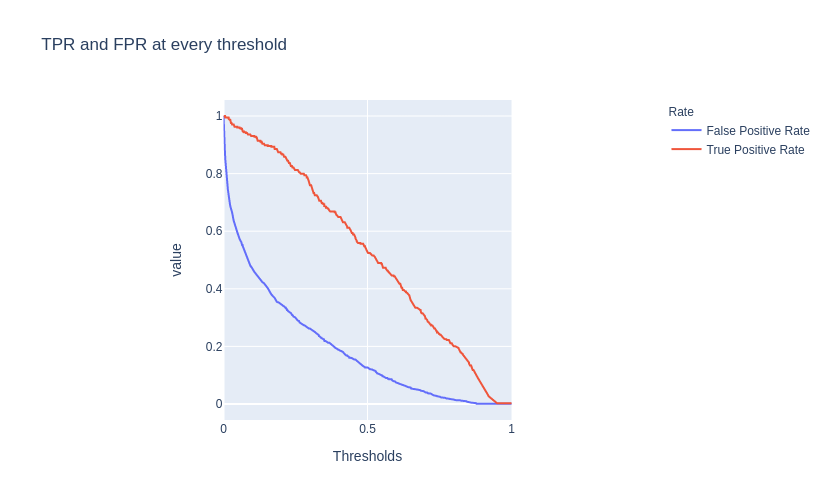

In [ ]:
df = pd.DataFrame({'False Positive Rate': fpr,
        'True Positive Rate': tpr }, index=thresholds)
df.index.name = "Thresholds"
df.columns.name = "Rate"
fig_thresh = px.line(df, 
    title='TPR and FPR at every threshold', width=700, height=500)
fig_thresh.update_yaxes(scaleanchor="x", scaleratio=1)
fig_thresh.update_xaxes(range=[0, 1], constrain='domain')
fig_thresh.show()

16 Variable-importance Measures

In [ ]:
model_exp = dx.Explainer(model, X_train, y_train, 
                  label = "Titanic RF Pipeline")

Preparation of a new explainer is initiated

  -> data              : 4507 rows 19 cols
  -> target variable   : 4507 values
  -> model_class       : lightgbm.sklearn.LGBMClassifier (default)
  -> label             : Titanic RF Pipeline
  -> predict function  : <function yhat_proba_default at 0x7febd5332790> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.000198, mean = 0.266, max = 0.963
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.892, mean = -0.00015, max = 0.919
  -> model_info        : package sklearn

A new explainer has been created!


In [ ]:
mp_rf = model_exp.model_parts()
mp_rf.result

,variable,dropout_loss,label
0,_full_model_,0.035230,Titanic RF Pipeline
1,PhoneService,0.037038,Titanic RF Pipeline
2,StreamingTV,0.037848,Titanic RF Pipeline
3,DeviceProtection,0.038778,Titanic RF Pipeline
4,Partner,0.039975,Titanic RF Pipeline
5,Dependents,0.040297,Titanic RF Pipeline
6,StreamingMovies,0.042118,Titanic RF Pipeline
7,MultipleLines,0.044248,Titanic RF Pipeline
8,SeniorCitizen,0.044818,Titanic RF Pipeline
9,InternetService,0.045739,Titanic RF Pipeline


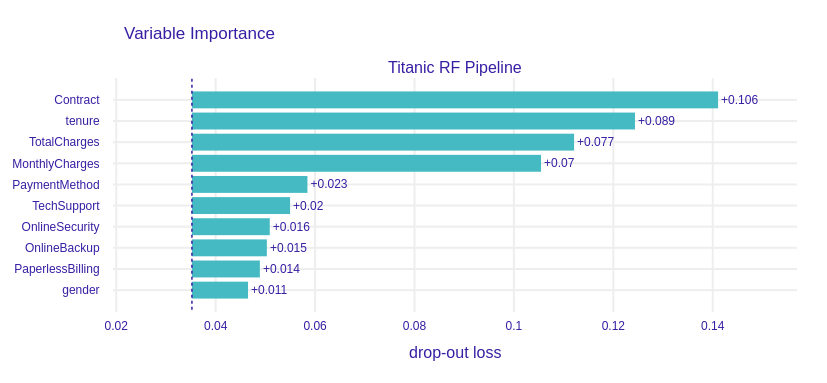

In [ ]:
mp_rf.plot()

In [ ]:
vi_grouped = model_exp.model_parts(
                variable_groups={'Finance': ['TotalCharges', 'tenure',"MonthlyCharges"],
                                   'Technical': ['Contract', 'PaymentMethod']})
vi_grouped.result

,variable,dropout_loss,label
0,_full_model_,0.035230,Titanic RF Pipeline
1,Technical,0.173671,Titanic RF Pipeline
2,Finance,0.224901,Titanic RF Pipeline
3,_baseline_,0.508684,Titanic RF Pipeline


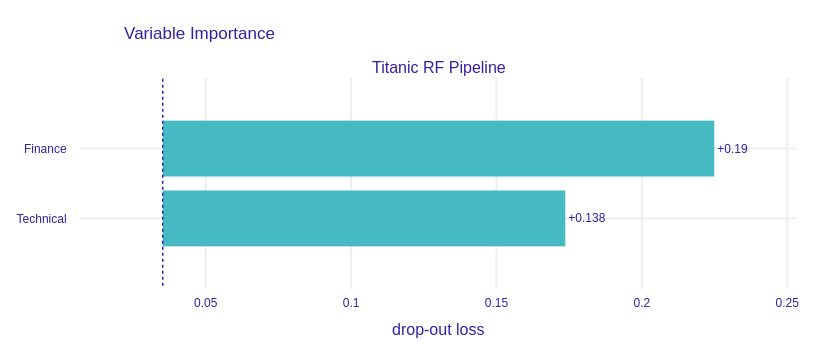

In [ ]:
vi_grouped.plot()

17 Partial-dependence Profiles

In [ ]:
model_exp = dx.Explainer(model, X_train, y_train, 
                  label = "Titanic RF Pipeline")

Preparation of a new explainer is initiated

  -> data              : 4507 rows 19 cols
  -> target variable   : 4507 values
  -> model_class       : lightgbm.sklearn.LGBMClassifier (default)
  -> label             : Titanic RF Pipeline
  -> predict function  : <function yhat_proba_default at 0x7febd5332790> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.000198, mean = 0.266, max = 0.963
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.892, mean = -0.00015, max = 0.919
  -> model_info        : package sklearn

A new explainer has been created!


In [ ]:
pd_rf = model_exp.model_profile(variables = ['MonthlyCharges', 'tenure'])
pd_rf.result

Calculating ceteris paribus: 100%|██████████| 2/2 [00:00<00:00,  9.56it/s]


,_vname_,_label_,_x_,_yhat_,_ids_
0,MonthlyCharges,Titanic RF Pipeline,18.250,0.165596,0
1,MonthlyCharges,Titanic RF Pipeline,19.254,0.226105,0
2,MonthlyCharges,Titanic RF Pipeline,20.258,0.189636,0
3,MonthlyCharges,Titanic RF Pipeline,21.262,0.207026,0
4,MonthlyCharges,Titanic RF Pipeline,22.266,0.207026,0
...,...,...,...,...,...
197,tenure,Titanic RF Pipeline,69.120,0.178710,0
198,tenure,Titanic RF Pipeline,69.840,0.189477,0
199,tenure,Titanic RF Pipeline,70.560,0.173923,0
200,tenure,Titanic RF Pipeline,71.280,0.173923,0


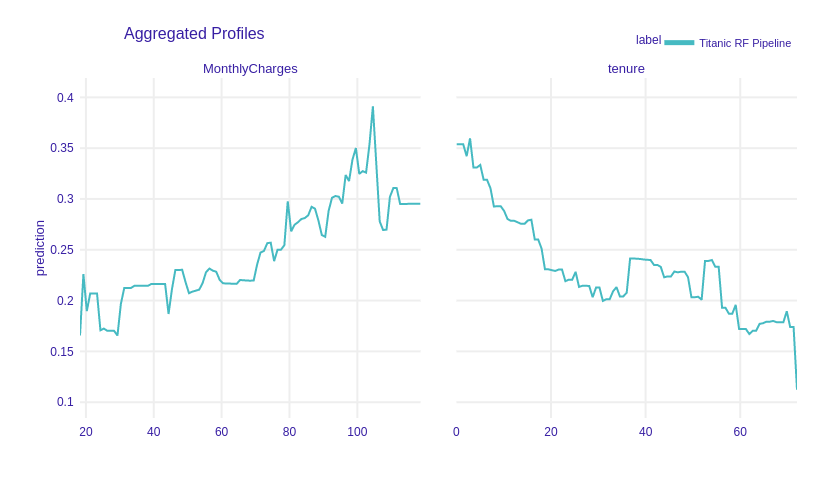

In [ ]:
pd_rf.plot()

In [ ]:
#pd_rf.plot(geom = 'profiles')  # Very long

Calculating ceteris paribus: 100%|██████████| 19/19 [00:00<00:00, 27.12it/s]


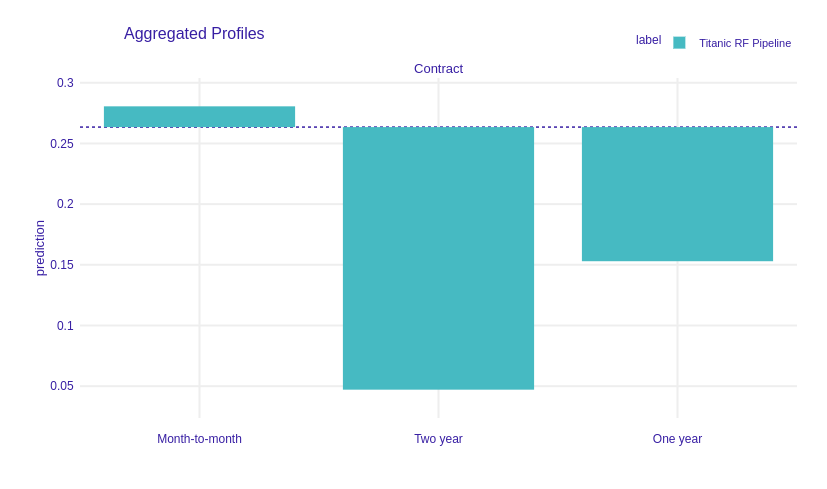

In [ ]:
mp_rf = model_exp.model_profile( variable_type = 'categorical')
mp_rf.plot(variables = ['Contract'])

Calculating ceteris paribus: 100%|██████████| 2/2 [00:00<00:00,  9.06it/s]


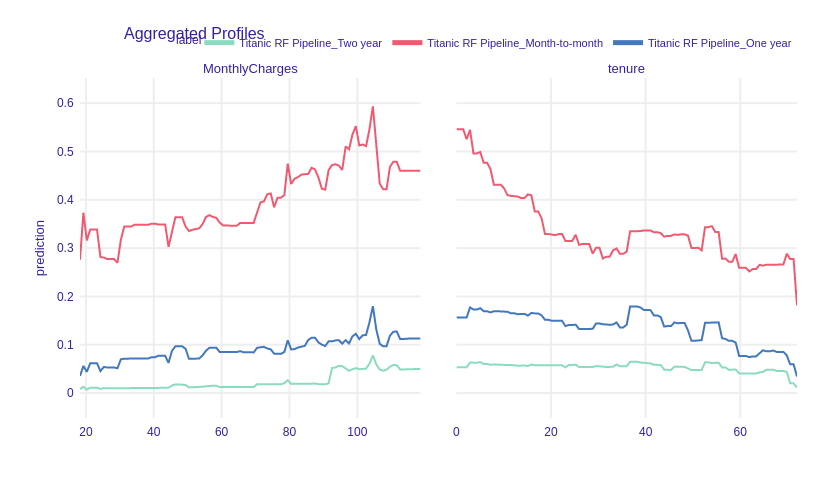

In [ ]:
mp_rf = model_exp.model_profile(groups = 'Contract', 
                                  variables = ['MonthlyCharges', 'tenure'])
mp_rf.plot()

18 Local-dependence and Accumulated-local Profiles

In [ ]:
model_exp = dx.Explainer(model, X_train, y_train, 
                  label = "Titanic RF Pipeline")

Preparation of a new explainer is initiated

  -> data              : 4507 rows 19 cols
  -> target variable   : 4507 values
  -> model_class       : lightgbm.sklearn.LGBMClassifier (default)
  -> label             : Titanic RF Pipeline
  -> predict function  : <function yhat_proba_default at 0x7febd5332790> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.000198, mean = 0.266, max = 0.963
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.892, mean = -0.00015, max = 0.919
  -> model_info        : package sklearn

A new explainer has been created!


In [ ]:
ld_rf = model_exp.model_profile(type = 'conditional')
ld_rf.result['_label_'] = 'LD profiles'
ld_rf.result

Calculating ceteris paribus: 100%|██████████| 19/19 [00:00<00:00, 28.72it/s]
/home/dnn/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version

Calculating conditional dependency: 100%|██████████| 4/4 [00:00<00:00, 27.56it/s]


,_vname_,_label_,_x_,_yhat_,_ids_
0,MonthlyCharges,LD profiles,18.250,0.123202,0
1,MonthlyCharges,LD profiles,19.254,0.181295,0
2,MonthlyCharges,LD profiles,20.258,0.149605,0
3,MonthlyCharges,LD profiles,21.262,0.176034,0
4,MonthlyCharges,LD profiles,22.266,0.177860,0
...,...,...,...,...,...
96,tenure,LD profiles,69.120,0.097934,0
97,tenure,LD profiles,69.840,0.093462,0
98,tenure,LD profiles,70.560,0.068715,0
99,tenure,LD profiles,71.280,0.067648,0


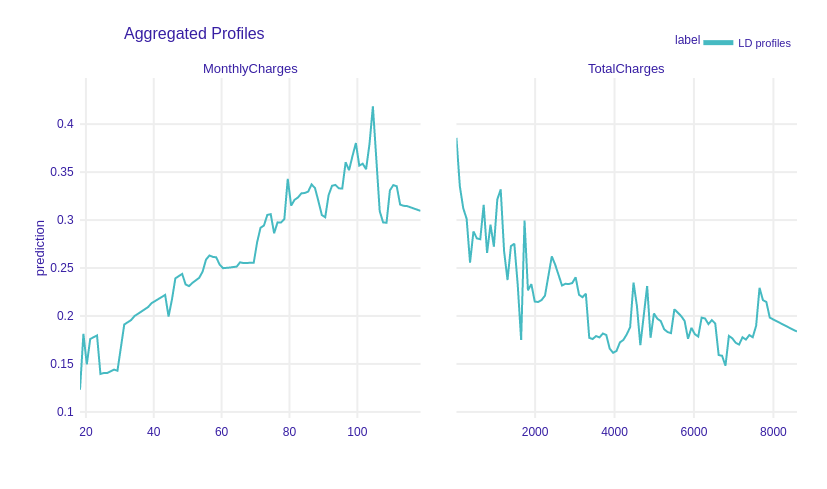

In [ ]:
ld_rf.plot(variables = ['MonthlyCharges', 'TotalCharges'])

In [ ]:
al_rf = model_exp.model_profile(type = 'accumulated')
al_rf.result['_label_'] = 'AL profiles'

Calculating ceteris paribus: 100%|██████████| 19/19 [00:00<00:00, 31.19it/s]
/home/dnn/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version

Calculating accumulated dependency: 100%|██████████| 4/4 [00:00<00:00, 14.38it/s]


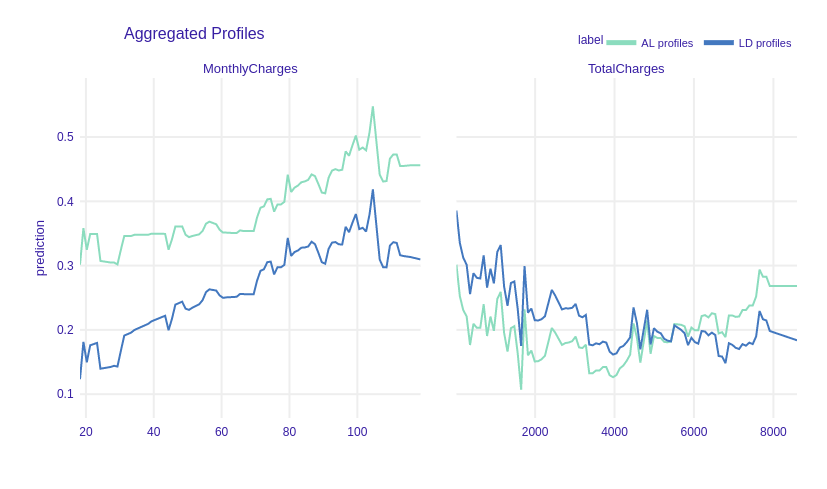

In [ ]:
al_rf.plot(ld_rf,variables = ['MonthlyCharges', 'TotalCharges'])

19 Residual-diagnostics Plots